## Import The Data

In [559]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [560]:
df = pd.read_csv("laptop_price.csv")

## Understand The Data

In [561]:
print(df.shape[0])
print(df.shape[1])

1303
13


In [562]:
df.isnull().sum()

laptop_ID           0
Company             0
Product             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price_euros         0
dtype: int64

In [563]:
df.dtypes

laptop_ID             int64
Company              object
Product              object
TypeName             object
Inches              float64
ScreenResolution     object
Cpu                  object
Ram                  object
Memory               object
Gpu                  object
OpSys                object
Weight               object
Price_euros         float64
dtype: object

In [564]:
df.describe()

,laptop_ID,Inches,Price_euros
count,1303.000000,1303.000000,1303.000000
mean,660.155794,15.017191,1123.686992
std,381.172104,1.426304,699.009043
min,1.000000,10.100000,174.000000
25%,331.500000,14.000000,599.000000
50%,659.000000,15.600000,977.000000
75%,990.500000,15.600000,1487.880000
max,1320.000000,18.400000,6099.000000


In [565]:
for column in df.columns:
    print(f"{column} : {len(df[column].unique())}")

laptop_ID : 1303
Company : 19
Product : 618
TypeName : 6
Inches : 18
ScreenResolution : 40
Cpu : 118
Ram : 9
Memory : 39
Gpu : 110
OpSys : 9
Weight : 179
Price_euros : 791


In [566]:
df.head(5)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


## Clean And Prepare The Data

In [567]:
df.rename(columns = {'Price_euros' : 'Price'}, inplace= True)  

In [568]:
df = df.join(pd.get_dummies(df['Company']))
df = df.drop("Company", axis= 1)

In [569]:
df = df.join(pd.get_dummies(df['TypeName']))
df = df.drop("TypeName", axis= 1)

In [570]:
df["ScreenResolution"] = df.ScreenResolution.str.split(" ").apply(lambda x: x[-1])
df["ScreenWitdh"] = df.ScreenResolution.str.split("x").apply(lambda x: x[0])
df["ScreenHeight"] = df.ScreenResolution.str.split("x").apply(lambda x: x[1])

df = df.drop("ScreenResolution", axis= 1)

In [571]:
df["CpuBrand"] = df.Cpu.str.split(" ").apply(lambda x: x[0])
df["CpuFrequency"] = df.Cpu.str.split(" ").apply(lambda x: x[-1])

df["CpuFrequency"] = df["CpuFrequency"].str[:-3]

df= df.drop("Cpu", axis= 1)

In [572]:
df["Ram"] = df["Ram"].str[:-2]

In [573]:
df['MemoryAmount'] = df.Memory.str.split(" ").apply(lambda x: x[0])
df['MemoryType'] = df.Memory.str.split(" ").apply(lambda x: x[1])

In [574]:
def turnMemoryIntoMb(value):
    if "GB" in value:
        return float(value[:value.find("GB")]) * 1000
    elif "TB" in value:
        return float(value[:value.find("TB")]) * 1000000


In [575]:
df["MemoryAmount"] = df["MemoryAmount"].apply(turnMemoryIntoMb)

df.drop("Memory", axis = 1, inplace=True)

In [576]:
df["Weight"] = df["Weight"].str[:-2]
df["Weight"] = df["Weight"].astype("float")

In [577]:
df["GpuBrand"] = df["Gpu"].str.split(" ").apply(lambda x: x[0])
df.drop("Gpu", axis= 1, inplace=True)

In [578]:
df = df.join(pd.get_dummies(df.OpSys))
df.drop("OpSys", axis = 1, inplace=True)

In [579]:
cpuCategories = pd.get_dummies(df.CpuBrand)
cpuCategories.columns = [col + "_CPU" for col in cpuCategories.columns]

df = df.join(cpuCategories)
df.drop("CpuBrand", axis = 1, inplace=True)

In [580]:
gpuCategories = pd.get_dummies(df.GpuBrand)
gpuCategories.columns = [col + "_GPU" for col in gpuCategories.columns]

df = df.join(gpuCategories)
df.drop("GpuBrand", axis = 1, inplace=True)

In [581]:
df["Ram"] = df["Ram"].astype("int")
df["CpuFrequency"] = df["CpuFrequency"].astype("float64")
df["ScreenWitdh"] = df["ScreenWitdh"].astype("int")
df["ScreenHeight"] = df["ScreenHeight"].astype("int")

In [582]:
df.columns

Index(['laptop_ID', 'Product', 'Inches', 'Ram', 'Weight', 'Price', 'Acer',
       'Apple', 'Asus', 'Chuwi', 'Dell', 'Fujitsu', 'Google', 'HP', 'Huawei',
       'LG', 'Lenovo', 'MSI', 'Mediacom', 'Microsoft', 'Razer', 'Samsung',
       'Toshiba', 'Vero', 'Xiaomi', '2 in 1 Convertible', 'Gaming', 'Netbook',
       'Notebook', 'Ultrabook', 'Workstation', 'ScreenWitdh', 'ScreenHeight',
       'CpuFrequency', 'MemoryAmount', 'MemoryType', 'Android', 'Chrome OS',
       'Linux', 'Mac OS X', 'No OS', 'Windows 10', 'Windows 10 S', 'Windows 7',
       'macOS', 'AMD_CPU', 'Intel_CPU', 'Samsung_CPU', 'AMD_GPU', 'ARM_GPU',
       'Intel_GPU', 'Nvidia_GPU'],
      dtype='object')

In [583]:
df.dtypes

laptop_ID               int64
Product                object
Inches                float64
Ram                     int64
Weight                float64
Price                 float64
Acer                     bool
Apple                    bool
Asus                     bool
Chuwi                    bool
Dell                     bool
Fujitsu                  bool
Google                   bool
HP                       bool
Huawei                   bool
LG                       bool
Lenovo                   bool
MSI                      bool
Mediacom                 bool
Microsoft                bool
Razer                    bool
Samsung                  bool
Toshiba                  bool
Vero                     bool
Xiaomi                   bool
2 in 1 Convertible       bool
Gaming                   bool
Netbook                  bool
Notebook                 bool
Ultrabook                bool
Workstation              bool
ScreenWitdh             int64
ScreenHeight            int64
CpuFrequen

## Data Analysis

In [584]:
df.head()

,laptop_ID,Product,Inches,Ram,Weight,Price,Acer,Apple,Asus,Chuwi,...,Windows 10 S,Windows 7,macOS,AMD_CPU,Intel_CPU,Samsung_CPU,AMD_GPU,ARM_GPU,Intel_GPU,Nvidia_GPU
0,1,MacBook Pro,13.3,8,1.37,1339.69,False,True,False,False,...,False,False,True,False,True,False,False,False,True,False
1,2,Macbook Air,13.3,8,1.34,898.94,False,True,False,False,...,False,False,True,False,True,False,False,False,True,False
2,3,250 G6,15.6,8,1.86,575.00,False,False,False,False,...,False,False,False,False,True,False,False,False,True,False
3,4,MacBook Pro,15.4,16,1.83,2537.45,False,True,False,False,...,False,False,True,False,True,False,True,False,False,False
4,5,MacBook Pro,13.3,8,1.37,1803.60,False,True,False,False,...,False,False,True,False,True,False,False,False,True,False


In [585]:
# Exclude 'laptop_ID' from non-numeric columns
non_numeric_cols = df.select_dtypes(exclude=['number']).columns.difference(['laptop_ID'])

print("Non-numeric columns:", non_numeric_cols)

# Convert object/string columns to boolean or numeric
for col in non_numeric_cols:
    # Attempt to convert to numeric first
    try:
        df[col] = pd.to_numeric(df[col], errors='raise')
        print(f"Column '{col}' successfully converted to numeric.")
    except ValueError:
        print(f"Column '{col}' cannot be directly converted to numeric. Attempting boolean conversion.")
        # Attempt to convert to boolean
        try:
            # If it contains only two unique values, convert to boolean
            if len(df[col].unique()) == 2:
                df[col] = df[col].map({df[col].unique()[0]: True, df[col].unique()[1]: False})
                print(f"Column '{col}' successfully converted to boolean.")
            else:
                print(f"Column '{col}' has more than 2 unique values and cannot be automatically converted to boolean. Dropping column.")
                df.drop(col, axis=1, inplace=True)
        except:
            print(f"Column '{col}' cannot be converted to boolean. Dropping column.")
            df.drop(col, axis=1, inplace=True)

print(df.dtypes)  # Print data types to verify

# Calculate correlation *after* conversion
print(df.corr())


Non-numeric columns: Index(['2 in 1 Convertible', 'AMD_CPU', 'AMD_GPU', 'ARM_GPU', 'Acer',
       'Android', 'Apple', 'Asus', 'Chrome OS', 'Chuwi', 'Dell', 'Fujitsu',
       'Gaming', 'Google', 'HP', 'Huawei', 'Intel_CPU', 'Intel_GPU', 'LG',
       'Lenovo', 'Linux', 'MSI', 'Mac OS X', 'Mediacom', 'MemoryType',
       'Microsoft', 'Netbook', 'No OS', 'Notebook', 'Nvidia_GPU', 'Product',
       'Razer', 'Samsung', 'Samsung_CPU', 'Toshiba', 'Ultrabook', 'Vero',
       'Windows 10', 'Windows 10 S', 'Windows 7', 'Workstation', 'Xiaomi',
       'macOS'],
      dtype='object')
Column '2 in 1 Convertible' successfully converted to numeric.
Column 'AMD_CPU' successfully converted to numeric.
Column 'AMD_GPU' successfully converted to numeric.
Column 'ARM_GPU' successfully converted to numeric.
Column 'Acer' successfully converted to numeric.
Column 'Android' successfully converted to numeric.
Column 'Apple' successfully converted to numeric.
Column 'Asus' successfully converted to numeric.
Col

In [586]:
df.dtypes

laptop_ID               int64
Inches                float64
Ram                     int64
Weight                float64
Price                 float64
Acer                     bool
Apple                    bool
Asus                     bool
Chuwi                    bool
Dell                     bool
Fujitsu                  bool
Google                   bool
HP                       bool
Huawei                   bool
LG                       bool
Lenovo                   bool
MSI                      bool
Mediacom                 bool
Microsoft                bool
Razer                    bool
Samsung                  bool
Toshiba                  bool
Vero                     bool
Xiaomi                   bool
2 in 1 Convertible       bool
Gaming                   bool
Netbook                  bool
Notebook                 bool
Ultrabook                bool
Workstation              bool
ScreenWitdh             int64
ScreenHeight            int64
CpuFrequency          float64
MemoryAmou

In [587]:
df.corr()

,laptop_ID,Inches,Ram,Weight,Price,Acer,Apple,Asus,Chuwi,Dell,...,Windows 10 S,Windows 7,macOS,AMD_CPU,Intel_CPU,Samsung_CPU,AMD_GPU,ARM_GPU,Intel_GPU,Nvidia_GPU
laptop_ID,1.000000,-0.087796,-0.028607,-0.011798,0.067830,-0.057721,-0.119585,-0.044252,-0.043348,-0.013628,...,-0.061942,0.194094,-0.158931,-0.055338,0.049765,0.039920,-0.089050,0.039920,0.094479,-0.037596
Inches,-0.087796,1.000000,0.237993,0.827631,0.068197,0.009435,-0.158850,0.112766,-0.017426,0.045288,...,-0.093285,-0.064775,-0.100867,0.129801,-0.122000,-0.052816,0.207023,-0.052816,-0.592264,0.486561
Ram,-0.028607,0.237993,1.000000,0.383874,0.743007,-0.138432,0.023950,0.088634,-0.035117,0.082241,...,-0.021374,-0.017529,0.028914,-0.104759,0.107051,-0.023894,-0.093119,-0.023894,-0.319551,0.415464
Weight,-0.011798,0.827631,0.383874,1.000000,0.210370,0.056444,-0.138191,0.101332,-0.022536,0.088465,...,-0.087904,-0.048100,-0.096042,0.062641,-0.057386,-0.037026,0.106519,-0.037026,-0.596378,0.565232
Price,0.067830,0.068197,0.743007,0.210370,1.000000,-0.208349,0.080688,-0.010376,-0.055646,0.048509,...,0.018312,0.152381,0.089928,-0.180111,0.181127,-0.018431,-0.199415,-0.018431,-0.184205,0.348797
Acer,-0.057721,0.009435,-0.138432,0.056444,-0.208349,1.000000,-0.037497,-0.108831,-0.014074,-0.159187,...,-0.023027,-0.055411,-0.029411,0.068130,-0.066566,-0.008119,-0.034859,-0.008119,0.005305,0.020848
Apple,-0.119585,-0.158850,0.023950,-0.138191,0.080688,-0.037497,1.000000,-0.047544,-0.006148,-0.069542,...,-0.010059,-0.024206,0.784352,-0.028607,0.028849,-0.003547,0.001749,-0.003547,0.078028,-0.085183
Asus,-0.044252,0.112766,0.088634,0.101332,-0.010376,-0.108831,-0.047544,1.000000,-0.017845,-0.201839,...,0.030999,-0.070257,-0.037291,0.038455,-0.036835,-0.010295,-0.073770,-0.010295,-0.106654,0.170742
Chuwi,-0.043348,-0.017426,-0.035117,-0.022536,-0.055646,-0.014074,-0.006148,-0.017845,1.000000,-0.026102,...,-0.003776,-0.009086,-0.004822,-0.010737,0.010828,-0.001331,-0.019232,-0.001331,0.043093,-0.031972
Dell,-0.013628,0.045288,0.082241,0.088465,0.048509,-0.159187,-0.069542,-0.201839,-0.026102,1.000000,...,-0.042706,-0.032633,-0.054545,-0.121448,0.122473,-0.015058,0.190722,-0.015058,-0.075707,-0.060187


In [588]:
targetedCorrelations = df.corr()['Price'].apply(abs).sort_values()

selectedFeatures = targetedCorrelations[-21:].index

selectedFeatures = list(selectedFeatures)

limitedDf = df[selectedFeatures]

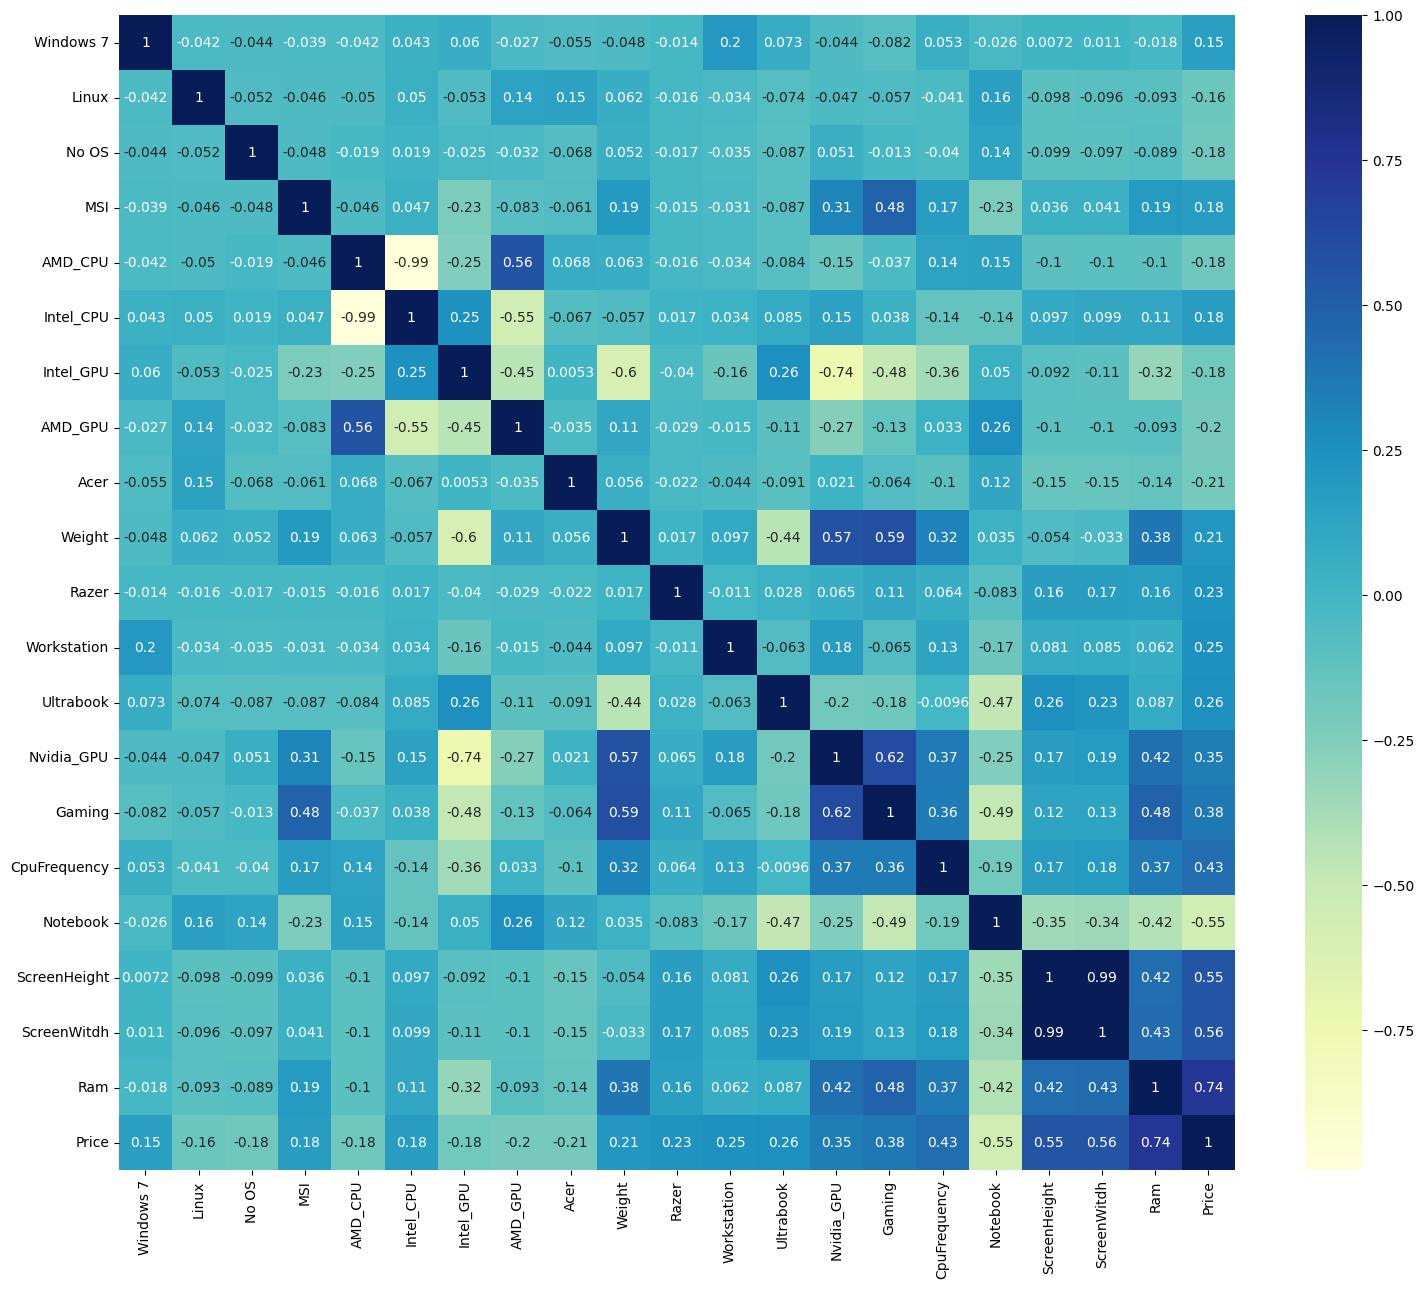

In [589]:
plt.figure(figsize= (18,15))
sns.heatmap(limitedDf.corr(), annot= True, cmap= "YlGnBu")

plt.show()

## Train the Model